# Semantic Segmentation of Aerial Imagery with Raster Vision 
## Part 7: Evaluating training performance and visualizing predictions

This tutorial series walks through an example of using [Raster Vision](https://rastervision.io/) to train a deep learning model to identify buildings in satellite imagery.</br>

*Primary Libraries and Tools*:

|Name|Description|Link|
|-|-|-|
| `Raster Vision ` | Library and framework for geospatial semantic segmentation, object detection, and chip classification in python| https://rastervision.io/ |
| `Apptainer` | Containerization software that allows for transportable and reproducible software | https://apptainer.org/ |
| `pandas` | Python library supporting dataframes and other datatypes for data analysis and manipulation | https://pandas.pydata.org/ |
| `geopandas` | Python library that extends pandas to support geospatial vector data and spatial operations | https://geopandas.org/en/stable/ |
| `rioxarray` | Python library supporting data structures and operations for geospatial raster data | https://github.com/corteva/rioxarray |
| `pathlib` | A Python library for handling files and paths in the filesystem | https://docs.python.org/3/library/pathlib.html |

*Prerequisites*:
  * Basic understanding of navigating the Linux command line, including navigating among directories and editing text files
  * Basic python skills, including an understanding of object-oriented programming, function calls, and basic data types
  * Basic understanding of shell scripts and job scheduling with SLURM for running code on Atlas
  * A SCINet account for running this tutorial on Atlas
  * **Completion of tutorial parts 1-6 of this series**

*Tutorials in this Series*:
  * 1\. **Tutorial Setup on SCINet**
  * 2\. **Overview of Deep Learning for Imagery and the Raster Vision Pipeline**
  * 3\. **Constructing and Exploring the Apptainer Image**
  * 4\. **Exploring the Dataset and Problem Space**
  * 5\. **Overview of Raster Vision Model Configuration and Setup**
  * 6\. **Breakdown of Raster Vision Code Version 1**
  * 7\. **Evaluating Training Performance and Visualizing Predictions <span style="color: red;">_(You are here)_</span>**
  * 8\. **Modifying Model Configuration - Hyperparameter Tuning**

<a id='step_7'></a>
## Evaluating Training Performance and Visualizing Predictions

Once training is complete, it is important to examine the metrics Raster Vision gathered during the training process. These metrics can help you evaluate how well your model performs, and how the model improved over the course of training. Model evaluation metrics are rich topics which we will not have time to discuss in much detail for this tutorial. We will visualize a handful of key metrics that Raster Vision logged during the training process.

Once the code you sbatch-ed in the previous tutorial has finished running, all of the model outputs will appear in the new `output1` directory. Raster Vision will produce a lot of output information, and we will only need to refer to some of it in this tutorial series. The Raster Vision pipeline will populate the `output1/` directory with the following four subdirectories: 
- `bundle/`, which contains a model bundle for deployment
- `eval/`, which contains our evaluation metrics
- `predict/`, which contains the model predictions on the validation and test sets
- `train/`, which contains information on the model training process

In this tutorial, we will examine some of the evaluation metrics in the `eval/` directory, information about the training process in the `train/` directory, and visualize some prediction rasters in the `predict/` directory.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
import rioxarray
import geopandas as gpd

Set the following variable, `output_dir` to specify the path of your `output1` directory.

In [11]:
# Update this path to refer to the output directory you just created
output_dir = Path("/PATH/TO/YOUR/rastervision/model/output1")

#### 1. Evaluating our Model Performance Metrics

First, we will look at the confusion matrix. This represents the proportion of true positive (TP), true negative (TN), false positive (FN), and false positive (FP) predictions in our validation set. If you are not familiar with confusion matricies, you can learn more about them [here](https://www.geeksforgeeks.org/confusion-matrix-machine-learning/).

Our evaluation metrics for validation scenes are stored in `output1/eval/validation_scenes/eval.json`. This file includes various metrics including all the values in our confusion matrix, precision, recall, f1 score, sensitivity, specificity, etc for each prediction class (building, background, null) and for each validation scene. If you are not familiar with precision, recall, and f1 scores, you can learn more [here](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9).

Here, we will define a function that will display our confusion matrix from the information in our eval.json file. We will input to this function the path to our output directory, and it will read in the evaluation metrics our model produced. This function will display a proportional confusion matrix, so each box in the confusion represents the total proportion of pixels that are within that category. Also, our confusion matrix will be greyscale colorcoded, so values closer to 1 will be closer to white, and values closer to 0 will be closer to black. Ideally, we'd like to see the FP and FN classes both be black, or close to 0.

In [24]:
def display_conf_mat(output_path: Path):
    eval_path = Path(output_path / "eval/validation_scenes/eval.json")
    with open(eval_path) as eval_file:
        eval = json.load(eval_file)
    metrics = eval["overall"][0]["conf_mat_frac_dict"]
    values = np.around(
        np.array([
                [metrics["TP"], metrics["FN"], metrics["TP"] + metrics["FN"]],
                [metrics["FP"], metrics["TN"], metrics["FP"] + metrics["TN"]],
                [metrics["TP"] + metrics["FP"], metrics["TN"] + metrics["FN"], 1]
        ]),
        decimals=3
    )
    true_labels = ["Actual positive", "Actual negative", "Total"]
    pred_labels = ["Pred positive", "Pred negative", "Total"]
    fig, ax = plt.subplots()
    im = ax.imshow(values, cmap="gray")
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(pred_labels)), labels=pred_labels)
    ax.set_yticks(np.arange(len(true_labels)), labels=true_labels)
    # Loop over data dimensions and create text annotations.
    for i in range(len(true_labels)):
        for j in range(len(pred_labels)):
            text = ax.text(j, i, values[i,j],
                           ha="center", va="center", color="r", fontsize="xx-large")
    ax.set_title("Confusion Matrix")
    fig.tight_layout()
    plt.show()

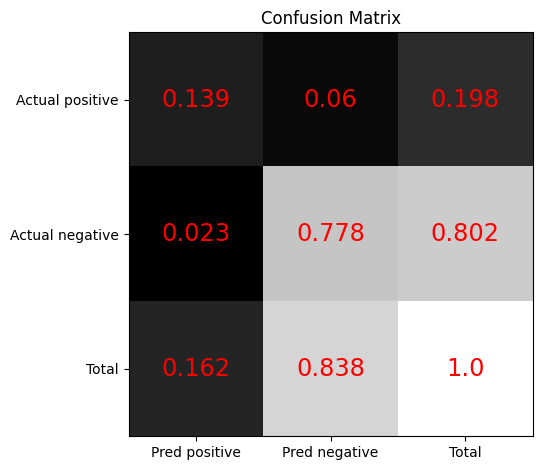

In [23]:
# Call this function on our output directory to view the confusion matrix
display_conf_mat(output_dir)

We can see that so far our mode does a pretty good job for our first attempt - we have low instances of False Positives and False Negatives. Lets take a look at some of the prediction rasters so we can see where the model tends to incorrectly classify pixels.

#### 2. Visualizing our Prediction Rasters
Let's define a function to visualize our predictions on the validation set. We will need to refer to the validation raster images stored in `/reference/workshops/rastervision/input/val/`, as well as the prediction rasters our model created, which are stored in our `output1/` directory. We have a total of 50 validation images, so we will use the `val_scene_index` variable to specify which of these validation images we would like to visualize.

In [13]:
def plot_prediction(output_dir: Path, val_scene_index: int):
    if val_scene_index not in range(0,50):
        print("Choose a valid index between 0 and 49")
        return
    # Read in input data
    val_data_dir = Path("/reference/workshops/rastervision/input/val/")
    raster_list = list(sorted(val_data_dir.glob('*.tif'))) # Sort files alphabetically
    raster_path = str(raster_list[val_scene_index])
    scene_id = raster_path.split("img")[1].split(".")[0]
    vector_filename = "buildings_AOI_2_Vegas_img" + scene_id + ".geojson"
    vector_path = Path(val_data_dir / vector_filename)
    raster = rioxarray.open_rasterio(raster_path)
    vector = gpd.read_file(vector_path)
    
    # Read in prediction raster
    prediction_path = Path(output_dir / "predict" / scene_id / "labels.tif")
    prediction = rioxarray.open_rasterio(prediction_path)

    # Display prediction raster and satellite image, both overlayed with the building outlines
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16,8))
    prediction.plot(ax=axs[0], levels=[0,1,2,3], colors = ['tomato', 'darkgreen', 'white'])
    raster_scaled = (raster - raster.min())/(raster.max() - raster.min())
    raster_scaled.plot.imshow(ax=axs[1])
    if len(vector) > 0:
        vector.boundary.plot(ax=axs[0], color="cyan")
        vector.boundary.plot(ax=axs[1], color="cyan")

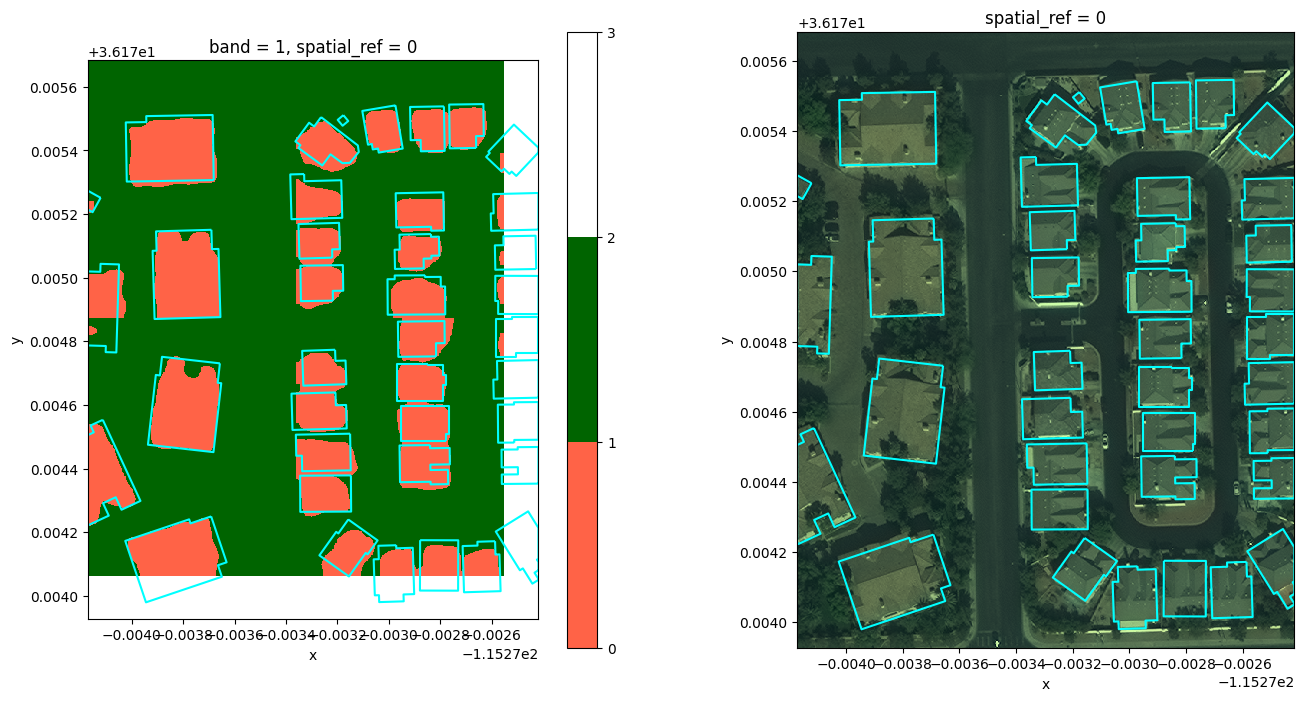

In [14]:
# Change the index here to view different validation scenes
plot_prediction(output_dir, 3)

At first glance, we can see that our model most commonly predicts pixels incorrectly around the edges of buildings, but it tends to label the centers of buildings correctly.</br> </br>
Take a look at the legend on the prediction raster. This has three levels: 0, 1 and 2. Levels 0 and 1 correspond to our ClassConfig's class ID's for the "building" and "background" classes respectively. Raster Vision includes a "null" class as well - this class is associated with source raster pixels with no data. On each prediction raster, we see that the model predicts the null class in the same place - a strip along the bottom and a strip along the right hand side. Our raster images have data in these areas, so initially it doesn't make sense why we are getting null values here. Here's what's going on: our images are all 650 by 650 pixels large, and our chip size is 300 by 300 pixels large. The "predict" stage of the Raster Vision pipeline creates chips out of our validation scenes in a sliding fashion from left to right and top to bottom. So, it doesn't reach the edges of the images, and thus predicts those areas as "null". Here's a visualization of how rastervision chips the prediction rasters. ![image](imgs/gridded300.png)
</br> We will fix this in the next version of our code. Before we get to that, let's see how our training loss, validation loss, and building f1 score changed during the model training process.

#### 3. Analyzing Model Training Process

Raster Vision stores training metrics per epoch in the file `train/log.csv`. This data has one row per epoch, and includes the training time, loss on the training and validation sets, as well as the precision, recall, and f1 scores for each class level. Let's take a look at this data.

In [15]:
# Load the logged metrics values.
training_metrics = pd.read_csv(output_dir / 'train/log.csv')
training_metrics

,epoch,train_loss,train_time,val_loss,avg_precision,avg_recall,avg_f1,building_precision,building_recall,building_f1,background_precision,background_recall,background_f1,null_precision,null_recall,null_f1,valid_time
0,0,0.262118,0:05:23.058337,0.498580,0.917954,0.921202,0.919575,0.863174,0.584023,0.696676,0.927998,0.983026,0.954719,0.0,0.0,0.0,0:00:08.848042
1,1,0.124622,0:05:19.499838,0.139147,0.947366,0.948655,0.948010,0.906201,0.756918,0.824859,0.955192,0.985106,0.969918,0.0,0.0,0.0,0:00:08.657106
2,2,0.099411,0:05:19.502072,0.101750,0.959116,0.959945,0.959530,0.910119,0.827963,0.867099,0.968298,0.984677,0.976419,0.0,0.0,0.0,0:00:08.656845


We want to visualize the training loss, the validation loss, and the building f1 score. Let's define a function to plot how these values changed during the training process.

In [16]:
def plot_metrics(output_path: Path):
    training_metrics = pd.read_csv(output_path / 'train/log.csv')
    training_loss = training_metrics[['epoch', 'train_loss']]
    val_loss = training_metrics[['epoch', 'val_loss']]
    building_f1 = training_metrics[['epoch', 'building_f1']]
    fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize = (10,16))
    training_loss.plot(x="epoch", y="train_loss", ax=ax1)
    val_loss.plot(x="epoch", y="val_loss", ax=ax2)
    building_f1.plot(x="epoch", y="building_f1", ax=ax3)

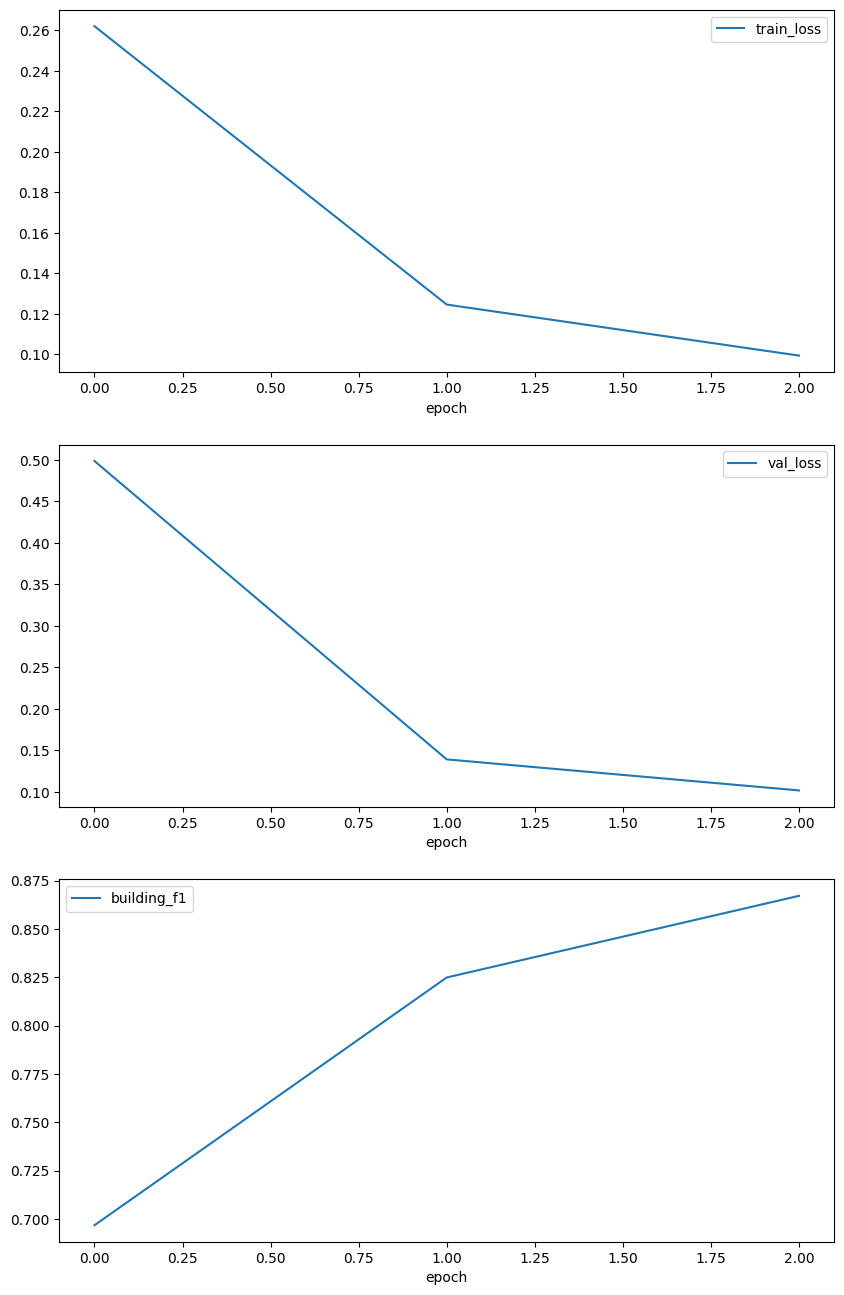

In [17]:
plot_metrics(output_dir)

We can see that our training loss and validation loss both decreased during training, and out building f1 score increased. This is what we expect to see, so we know we are on the right track.

In the next few tutorials, we will apply modifications to our model, and see how these changes affect our model output.